In [1]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q kaggle Pillow matplotlib tqdm wandb tensorboard
!pip install -q torchmetrics pytorch-lightning

import os
import sys
import re
import json
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
from google.colab import files

warnings.filterwarnings('ignore')

# --- 1. Setup & Configuration ---

# Check if kaggle.json exists, if not upload it
if not os.path.exists('/root/.kaggle/kaggle.json'):
    os.makedirs('/root/.kaggle', exist_ok=True)
    print("Please upload your kaggle.json file:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        os.rename(fn, f'/root/.kaggle/{fn}')
    !chmod 600 /root/.kaggle/kaggle.json
    print("Kaggle API configured!")
else:
    print("Kaggle API already configured")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class Config:
    # Data
    DATASET_SLUG = "ebrahimelgazar/pixel-art"
    RAW_DIR = Path("/content/data/raw")
    CACHE_DIR = Path("/content/data/cache")
    OUTPUT_DIR = Path("/content/outputs")

    # Model - Optimized for pixel art
    IMAGE_SIZE = 32
    NOISE_DIM = 100
    CLASS_EMBED_DIM = 50
    NUM_CLASSES = 5  # Will be updated dynamically
    CHANNELS = 3

    # Generator
    G_FEATURE_MAPS = 64

    # Discriminator
    D_FEATURE_MAPS = 64

    # Training
    BATCH_SIZE = 64       # Smaller batch size can sometimes help gradient updates happen more often
    EPOCHS = 200
    LR_G = 0.0002         # Generator LR
    LR_D = 0.00003         # Discriminator LR (Balanced with Generator)
    BETA1 = 0.5
    BETA2 = 0.999

    # GAN specific
    N_CRITIC = 1          # Train discriminator n times per generator
    LAMBDA_DIV = 0.34      # Weight for diversity loss

    # Save & Viz
    SAVE_INTERVAL = 5

config = Config()

config.RAW_DIR.mkdir(parents=True, exist_ok=True)
config.CACHE_DIR.mkdir(parents=True, exist_ok=True)
config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 2. Data Loading & Processing ---

print(f"Downloading dataset: {config.DATASET_SLUG}")
!kaggle datasets download -d {config.DATASET_SLUG} -p {config.RAW_DIR} --unzip -q
print("Download complete!")

CSV_PATH = config.RAW_DIR / "labels.csv"
df = pd.read_csv(CSV_PATH).rename(columns={"Image Index": "id", "Label": "class_name"})
df["id"] = df["id"].astype(int)

# Filter classes to ensure we have enough data (optional, but good for stability)
# Taking top 10 most common classes for better results if dataset is imbalanced
top_classes = df['class_name'].value_counts().nlargest(10).index
df = df[df['class_name'].isin(top_classes)].reset_index(drop=True)

df["class_idx"], class_names = pd.factorize(df["class_name"], sort=True)
class_to_idx = {name: int(i) for i, name in enumerate(class_names)}
idx_to_class = {int(i): name for i, name in enumerate(class_names)}

config.NUM_CLASSES = len(class_names)
print(f"Found {config.NUM_CLASSES} classes: {list(class_to_idx.keys())}")

# Map IDs to file paths
pat = re.compile(r"image_(\d+)", re.IGNORECASE)
ALLOWED_EXT = {".png", ".jpg", ".jpeg", ".bmp", ".gif", ".webp"}
id2path = {}
for p in config.RAW_DIR.rglob("*"):
    if p.suffix.lower() in ALLOWED_EXT:
        m = pat.search(p.name)
        if m:
            id2path[int(m.group(1))] = str(p.resolve())

df["path"] = df["id"].map(id2path)
df = df[df["path"].notna()].reset_index(drop=True)

class PixelArtDataset(Dataset):
    def __init__(self, df, transform=None, image_size=32):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.transform = transform or self.default_transform()

    def default_transform(self):
        return transforms.Compose([
            transforms.Resize((self.image_size, self.image_size),
                            interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["path"]).convert("RGB")

        # Fix BGR if needed
        arr = np.array(image)
        if arr.mean() < 50:
            arr = arr[..., [2, 1, 0]]
            image = Image.fromarray(arr)

        if self.transform:
            image = self.transform(image)

        label = row["class_idx"]
        return image, label

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df["class_idx"], random_state=42)

train_dataset = PixelArtDataset(train_df, image_size=config.IMAGE_SIZE)
val_dataset = PixelArtDataset(val_df, image_size=config.IMAGE_SIZE)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

# --- 3. Model Definition (Improved) ---



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 61.2 MB/s eta 0:00:00
Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API configured!
Using device: cuda
Dataset URL: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art
License(s): apache-2.0
Download complete!
Found 5 classes: ['[0. 0. 0. 0. 1.]', '[0. 0. 0. 1. 0.]', '[0. 0. 1. 0. 0.]', '[0. 1. 0. 0. 0.]', '[1. 0. 0. 0. 0.]']


Starting training...


Epoch 1/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/1257 [00:00<?, ?it/s]

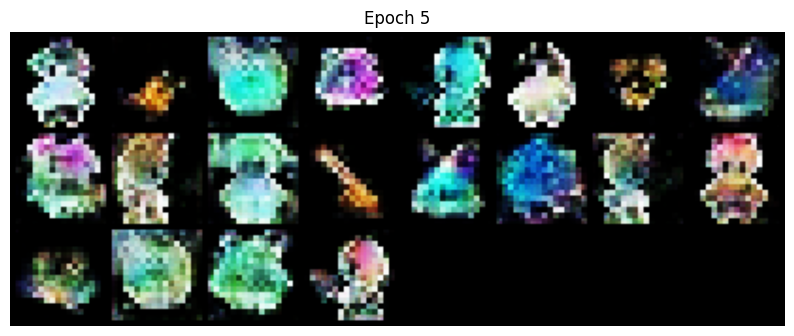

Epoch 6/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0> 
  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():^
^ ^ ^   ^ ^ ^^^^^^^^^^^^^^^^^^^

Epoch 7/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/1257 [00:00<?, ?it/s]

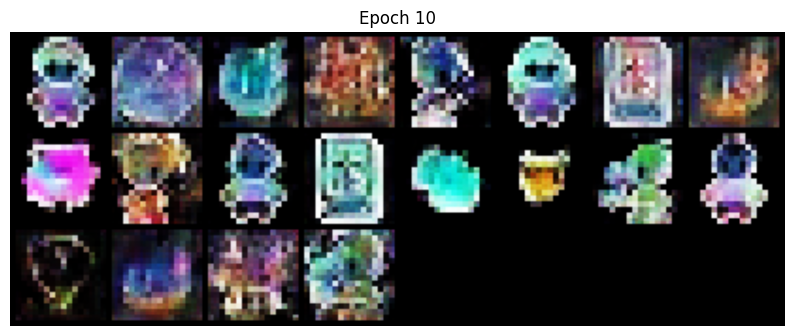

Epoch 11/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive(): 
    ^ ^^ ^ ^ ^ ^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ 
   File "/usr/lib/pyth

Epoch 15/200:   0%|          | 0/1257 [00:00<?, ?it/s]

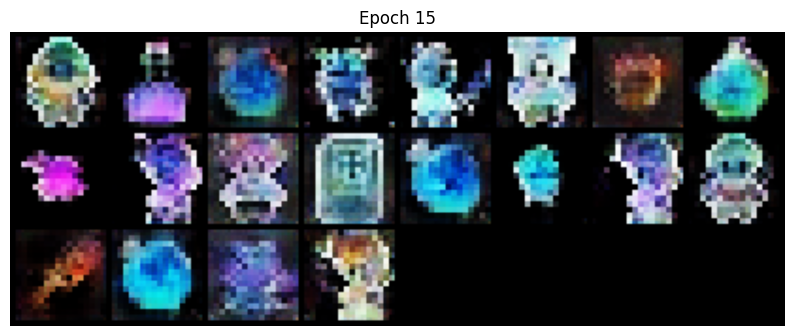

Epoch 16/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/1257 [00:00<?, ?it/s]

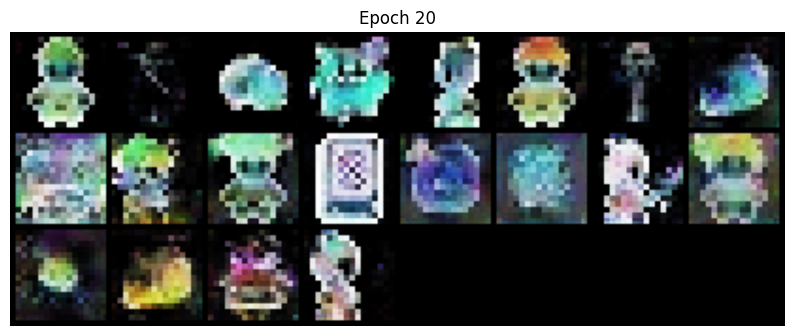

Epoch 21/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/1257 [00:00<?, ?it/s]

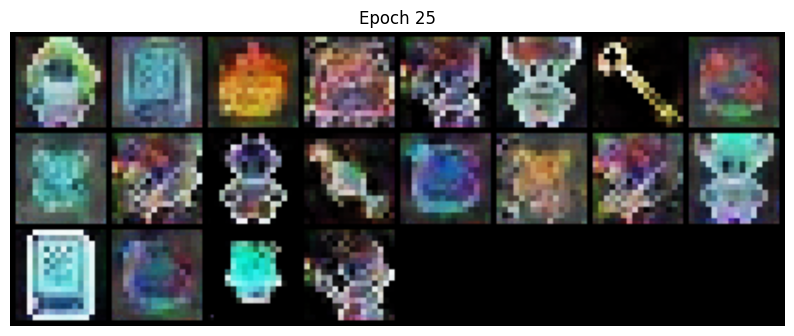

Epoch 26/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0>

 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()  
 ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():
^ ^   ^  ^ ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
 ^    
  File "/usr/lib/

Epoch 27/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/1257 [00:00<?, ?it/s]

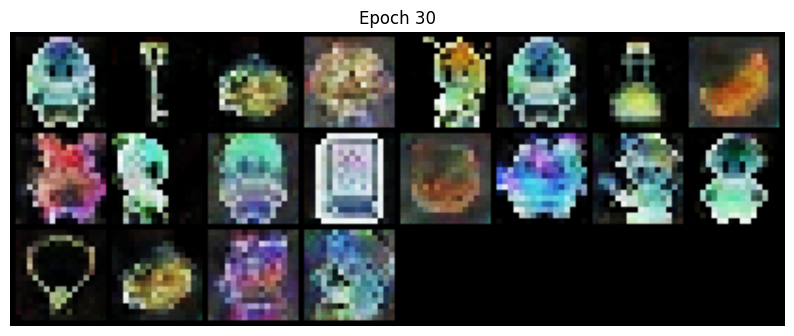

Epoch 31/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 32/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 33/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 34/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0>  
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
 ^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():^
^ ^ ^ ^^ ^ ^  ^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^^ ^ ^ ^ ^  
      File "/usr/

Epoch 35/200:   0%|          | 0/1257 [00:00<?, ?it/s]

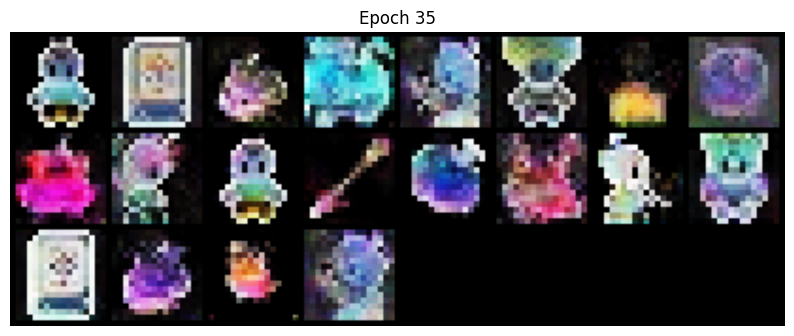

Epoch 36/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 37/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 38/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 39/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 40/200:   0%|          | 0/1257 [00:00<?, ?it/s]

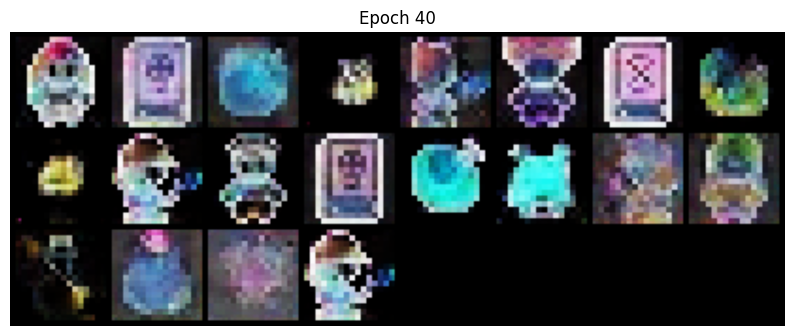

Epoch 41/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 42/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 43/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 44/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Epoch 45/200:   0%|          | 0/1257 [00:00<?, ?it/s]

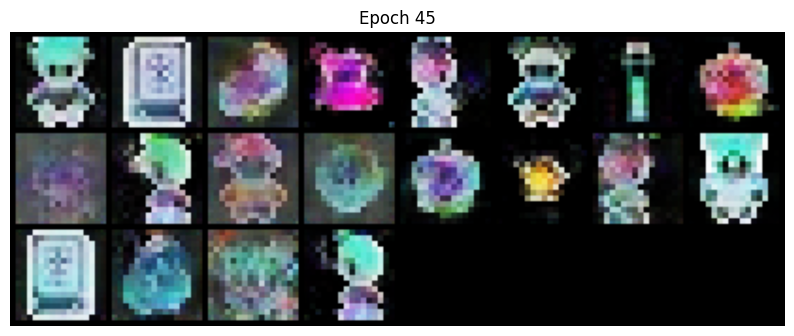

Epoch 46/200:   0%|          | 0/1257 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7afec25b18a0>
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

     self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive(): 
        ^ ^^  ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class MinibatchStdDev(nn.Module):
    """
    Minibatch Standard Deviation Layer
    Calculates the standard deviation across the batch and appends it as a feature map.
    Helps prevents mode collapse by allowing the discriminator to see if the batch lacks diversity.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # x shape: (B, C, H, W)
        # Calculate std across batch (dim 0)
        std = torch.std(x, dim=0, keepdim=True)
        # Average std across features and pixels -> single scalar
        mean_std = torch.mean(std)
        # Expand to feature map size
        b, c, h, w = x.size()
        feature_map = mean_std.expand(b, 1, h, w)
        # Concatenate
        return torch.cat([x, feature_map], dim=1)

class PixelArtGenerator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=10, class_embed_dim=50, channels=3, feature_maps=64):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, class_embed_dim)
        input_dim = noise_dim + class_embed_dim

        self.project = nn.Sequential(
            nn.Linear(input_dim, feature_maps * 8 * 4 * 4),
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            # 4x4 -> 8x8
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(feature_maps * 8, feature_maps * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            # 8x8 -> 16x16
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(feature_maps * 4, feature_maps * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            # 16x16 -> 32x32
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(feature_maps * 2, feature_maps, 3, 1, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            nn.Conv2d(feature_maps, channels, 3, 1, 1),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, noise, labels):
        label_embed = self.label_embedding(labels)
        gen_input = torch.cat([noise, label_embed], dim=1)
        x = self.project(gen_input)
        x = x.view(x.size(0), -1, 4, 4)
        return self.main(x)

class PixelArtDiscriminator(nn.Module):
    def __init__(self, num_classes=10, channels=3, feature_maps=64):
        super().__init__()

        self.conv_layers = nn.Sequential(
            # 32x32 -> 16x16
            nn.utils.spectral_norm(nn.Conv2d(channels, feature_maps, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # 16x16 -> 8x8
            nn.utils.spectral_norm(nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # 8x8 -> 4x4
            nn.utils.spectral_norm(nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Add Minibatch StdDev Layer
            MinibatchStdDev(),

            # 4x4 -> 2x2
            # Input channels increase by 1 because of MinibatchStdDev
            nn.utils.spectral_norm(nn.Conv2d(feature_maps * 4 + 1, feature_maps * 8, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Output layers
        self.adv_layer = nn.Linear(feature_maps * 8 * 2 * 2, 1)
        self.aux_layer = nn.Linear(feature_maps * 8 * 2 * 2, num_classes)
        self.apply(weights_init)

    def forward(self, img):
        out = self.conv_layers(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity, label

# --- 4. Trainer with Diversity Loss ---

class CGANTrainer:
    def __init__(self, generator, discriminator, train_loader, val_loader, config, device):
        self.G = generator
        self.D = discriminator
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = device

        self.opt_G = torch.optim.Adam(self.G.parameters(), lr=config.LR_G, betas=(config.BETA1, config.BETA2))
        self.opt_D = torch.optim.Adam(self.D.parameters(), lr=config.LR_D, betas=(config.BETA1, config.BETA2))
        self.auxiliary_loss = nn.CrossEntropyLoss()

        # Metrics history
        self.g_losses = []
        self.d_losses = []

    def train_epoch(self, epoch):
        self.G.train()
        self.D.train()

        epoch_g_loss = 0
        epoch_d_loss = 0

        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch}/{self.config.EPOCHS}")

        for i, (real_imgs, labels) in enumerate(pbar):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(self.device)
            labels = labels.to(self.device)

            # --- Train Discriminator ---
            self.opt_D.zero_grad()

            # Real
            real_pred, real_aux = self.D(real_imgs)
            d_real_loss = torch.mean(nn.ReLU(inplace=True)(1.0 - real_pred)) + self.auxiliary_loss(real_aux, labels)

            # Fake
            z = torch.randn(batch_size, self.config.NOISE_DIM, device=self.device)
            fake_imgs = self.G(z, labels)
            fake_pred, _ = self.D(fake_imgs.detach()) # Detach G to avoid training it
            d_fake_loss = torch.mean(nn.ReLU(inplace=True)(1.0 + fake_pred))

            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            self.opt_D.step()

            # --- Train Generator ---
            if i % self.config.N_CRITIC == 0:
                self.opt_G.zero_grad()

                # 1. Adversarial Loss (Classic)
                z = torch.randn(batch_size, self.config.NOISE_DIM, device=self.device)
                gen_imgs = self.G(z, labels)
                validity, pred_label = self.D(gen_imgs)

                g_adv_loss = -torch.mean(validity)
                g_aux_loss = self.auxiliary_loss(pred_label, labels)

                # 2. Diversity Loss (New!)
                # Generate a second batch with the SAME labels but DIFFERENT noise
                z2 = torch.randn(batch_size, self.config.NOISE_DIM, device=self.device)
                gen_imgs2 = self.G(z2, labels)

                # We want to MAXIMIZE the difference between images (gen_imgs vs gen_imgs2)
                # relative to the difference in noise (z vs z2)
                # Loss = 1 / (Distance + epsilon)
                lz = torch.mean(torch.abs(gen_imgs - gen_imgs2)) / torch.mean(torch.abs(z - z2))
                eps = 1e-5
                diversity_loss = 1 / (lz + eps)

                # Total Generator Loss
                g_loss = g_adv_loss + g_aux_loss + (self.config.LAMBDA_DIV * diversity_loss)

                g_loss.backward()
                self.opt_G.step()

                epoch_g_loss += g_loss.item()

            epoch_d_loss += d_loss.item()

            pbar.set_postfix({
                'D_loss': f"{d_loss.item():.3f}",
                'G_loss': f"{g_loss.item():.3f}" if 'g_loss' in locals() else "N/A"
            })

        # Logging
        self.g_losses.append(epoch_g_loss / len(self.train_loader))
        self.d_losses.append(epoch_d_loss / len(self.train_loader))

    def save_samples(self, epoch):
        self.G.eval()
        with torch.no_grad():
            # Generate one sample for each class
            n_classes = self.config.NUM_CLASSES
            labels = torch.arange(n_classes, device=self.device).repeat(4) # 4 examples per class
            labels = labels[:32] # Limit to 32 total
            z = torch.randn(len(labels), self.config.NOISE_DIM, device=self.device)
            fake_imgs = self.G(z, labels)

            # Denormalize
            fake_imgs = fake_imgs * 0.5 + 0.5
            save_image(fake_imgs, self.config.OUTPUT_DIR / f"samples_{epoch}.png", nrow=8, normalize=False)

            # Show
            grid = make_grid(fake_imgs, nrow=8)
            plt.figure(figsize=(10, 4))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.title(f"Epoch {epoch}")
            plt.axis('off')
            plt.show()

    def train(self, epochs):
        print("Starting training...")
        for epoch in range(1, epochs + 1):
            self.train_epoch(epoch)
            if epoch % self.config.SAVE_INTERVAL == 0:
                self.save_samples(epoch)

                # Save checkpoint
                torch.save(self.G.state_dict(), self.config.OUTPUT_DIR / "generator_latest.pt")
                torch.save(self.D.state_dict(), self.config.OUTPUT_DIR / "discriminator_latest.pt")

# --- 5. Run ---

generator = PixelArtGenerator(
    noise_dim=config.NOISE_DIM,
    num_classes=config.NUM_CLASSES,
    class_embed_dim=config.CLASS_EMBED_DIM,
    channels=config.CHANNELS,
    feature_maps=config.G_FEATURE_MAPS
).to(device)

discriminator = PixelArtDiscriminator(
    num_classes=config.NUM_CLASSES,
    channels=config.CHANNELS,
    feature_maps=config.D_FEATURE_MAPS
).to(device)

trainer = CGANTrainer(generator, discriminator, train_loader, val_loader, config, device)
trainer.train(epochs=config.EPOCHS)